# Init the workspace

In [0]:

#from google.colab import drive
#drive.mount('/content/drive')


In [0]:
import os
import re
import json
import string
import zipfile
import operator 
import numpy as np
import tensorflow
from os import path
from collections import Counter
from urllib.request import urlretrieve
import sklearn
from sklearn.manifold import TSNE
from nltk.tokenize.treebank import TreebankWordTokenizer
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import gc
import random
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

from keras.preprocessing import text
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras import optimizers
from keras.layers import Dense, Input, LSTM, Embedding,Activation,Flatten,merge,TimeDistributed,CuDNNGRU,Bidirectional,BatchNormalization,Dropout
from keras.layers.merge import concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import concatenate,subtract,add,maximum,multiply,Layer,Lambda
from keras.backend import backend as K
from keras import regularizers


In [0]:
# Info on how to get your api key (kaggle.json) here: https://github.com/Kaggle/kaggle-api#api-credentials
!pip install kaggle
api_token = {"username":"nopenoped ","key":"a257127ad645e140f0940f6556518e1a"}

os.environ['KAGGLE_USERNAME'] = "nopenoped"
os.environ['KAGGLE_KEY'] = "a257127ad645e140f0940f6556518e1a"

!mkdir /root/.kaggle
!echo '{"username":"nopenoped","key":"a257127ad645e140f0940f6556518e1a"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
if not os.path.exists("/content/datasets/kaggle-dataset"):
    os.makedirs("/content/datasets/kaggle-dataset")

os.chdir('/content/datasets/kaggle-dataset')
!kaggle datasets download supertaz/pretrained-bert-including-scripts
!kaggle datasets download -d yekenot/fasttext-crawl-300d-2m
!kaggle datasets download -d takuok/glove840b300dtxt
!kaggle competitions download -c efreiparisdeeplearning2019

for file in os.listdir():
    if(file.endswith('.zip')):
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()

mkdir: cannot create directory ‘/root/.kaggle’: File exists
pretrained-bert-including-scripts.zip: Skipping, found more recently modified local copy (use --force to force download)
fasttext-crawl-300d-2m.zip: Skipping, found more recently modified local copy (use --force to force download)
glove840b300dtxt.zip: Skipping, found more recently modified local copy (use --force to force download)
example_submission_test.csv: Skipping, found more recently modified local copy (use --force to force download)
dataset_test_no_labels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
dataset_train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


# Creating a class to pre process the data

---



In [0]:
class PreprocessingData:
  def __init__(self):
    symbols_to_delete = '\n🍕\r🐵😑\xa0\ue014\t\uf818\uf04a\xad😢🐶️\uf0e0😜😎👊\u200b\u200e😁عدويهصقأناخلىبمغر😍💖💵Е👎😀😂\u202a\u202c🔥😄🏻💥ᴍʏʀᴇɴᴅᴏᴀᴋʜᴜʟᴛᴄᴘʙғᴊᴡɢ😋👏שלוםבי😱‼\x81エンジ故障\u2009🚌ᴵ͞🌟😊😳😧🙀😐😕\u200f👍😮😃😘אעכח💩💯⛽🚄🏼ஜ😖ᴠ🚲‐😟😈💪🙏🎯🌹😇💔😡\x7f👌ἐὶήιὲκἀίῃἴξ🙄Ｈ😠\ufeff\u2028😉😤⛺🙂\u3000تحكسة👮💙فزط😏🍾🎉😞\u2008🏾😅😭👻😥😔😓🏽🎆🍻🍽🎶🌺🤔😪\x08‑🐰🐇🐱🙆😨🙃💕𝘊𝘦𝘳𝘢𝘵𝘰𝘤𝘺𝘴𝘪𝘧𝘮𝘣💗💚地獄谷улкнПоАН🐾🐕😆ה🔗🚽歌舞伎🙈😴🏿🤗🇺🇸мυтѕ⤵🏆🎃😩\u200a🌠🐟💫💰💎эпрд\x95🖐🙅⛲🍰🤐👆🙌\u2002💛🙁👀🙊🙉\u2004ˢᵒʳʸᴼᴷᴺʷᵗʰᵉᵘ\x13🚬🤓\ue602😵άοόςέὸתמדףנרךצט😒͝🆕👅👥👄🔄🔤👉👤👶👲🔛🎓\uf0b7\uf04c\x9f\x10成都😣⏺😌🤑🌏😯ех😲Ἰᾶὁ💞🚓🔔📚🏀👐\u202d💤🍇\ue613小土豆🏡❔⁉\u202f👠》कर्मा🇹🇼🌸蔡英文🌞🎲レクサス😛外国人关系Сб💋💀🎄💜🤢َِьыгя不是\x9c\x9d🗑\u2005💃📣👿༼つ༽😰ḷЗз▱ц￼🤣卖温哥华议会下降你失去所有的钱加拿大坏税骗子🐝ツ🎅\x85🍺آإشء🎵🌎͟ἔ油别克🤡🤥😬🤧й\u2003🚀🤴ʲшчИОРФДЯМюж😝🖑ὐύύ特殊作戦群щ💨圆明园קℐ🏈😺🌍⏏ệ🍔🐮🍁🍆🍑🌮🌯🤦\u200d𝓒𝓲𝓿𝓵안영하세요ЖљКћ🍀😫🤤ῦ我出生在了可以说普通话汉语好极🎼🕺🍸🥂🗽🎇🎊🆘🤠👩🖒🚪天一家⚲\u2006⚭⚆⬭⬯⏖新✀╌🇫🇷🇩🇪🇮🇬🇧😷🇨🇦ХШ🌐\x1f杀鸡给猴看ʁ𝗪𝗵𝗲𝗻𝘆𝗼𝘂𝗿𝗮𝗹𝗶𝘇𝗯𝘁𝗰𝘀𝘅𝗽𝘄𝗱📺ϖ\u2000үսᴦᎥһͺ\u2007հ\u2001ɩｙｅ൦ｌƽｈ𝐓𝐡𝐞𝐫𝐮𝐝𝐚𝐃𝐜𝐩𝐭𝐢𝐨𝐧Ƅᴨןᑯ໐ΤᏧ௦Іᴑ܁𝐬𝐰𝐲𝐛𝐦𝐯𝐑𝐙𝐣𝐇𝐂𝐘𝟎ԜТᗞ౦〔Ꭻ𝐳𝐔𝐱𝟔𝟓𝐅🐋ﬃ💘💓ё𝘥𝘯𝘶💐🌋🌄🌅𝙬𝙖𝙨𝙤𝙣𝙡𝙮𝙘𝙠𝙚𝙙𝙜𝙧𝙥𝙩𝙪𝙗𝙞𝙝𝙛👺🐷ℋ𝐀𝐥𝐪🚶𝙢Ἱ🤘ͦ💸ج패티Ｗ𝙇ᵻ👂👃ɜ🎫\uf0a7БУі🚢🚂ગુજરાતીῆ🏃𝓬𝓻𝓴𝓮𝓽𝓼☘﴾̯﴿₽\ue807𝑻𝒆𝒍𝒕𝒉𝒓𝒖𝒂𝒏𝒅𝒔𝒎𝒗𝒊👽😙\u200cЛ‒🎾👹⎌🏒⛸公寓养宠物吗🏄🐀🚑🤷操美𝒑𝒚𝒐𝑴🤙🐒欢迎来到阿拉斯ספ𝙫🐈𝒌𝙊𝙭𝙆𝙋𝙍𝘼𝙅ﷻ🦄巨收赢得白鬼愤怒要买额ẽ🚗🐳𝟏𝐟𝟖𝟑𝟕𝒄𝟗𝐠𝙄𝙃👇锟斤拷𝗢𝟳𝟱𝟬⦁マルハニチロ株式社⛷한국어ㄸㅓ니͜ʖ𝘿𝙔₵𝒩ℯ𝓁𝒶𝓉𝓇𝓊𝓃𝓈𝓅ℴ𝒻𝒽𝓀𝓌𝒸𝓎𝙏ζ𝙟𝘃𝗺𝟮𝟭𝟯𝟲👋🦊多伦🐽🎻🎹⛓🏹🍷🦆为和中友谊祝贺与其想象对法如直接问用自己猜本传教士没积唯认识基督徒曾经让相信耶稣复活死怪他但当们聊些政治题时候战胜因圣把全堂结婚孩恐惧且栗谓这样还♾🎸🤕🤒⛑🎁批判检讨🏝🦁🙋😶쥐스탱트뤼도석유가격인상이경제황을렵게만들지않록잘관리해야합다캐나에서대마초와화약금의품런성분갈때는반드시허된사용🔫👁凸ὰ💲🗯𝙈Ἄ𝒇𝒈𝒘𝒃𝑬𝑶𝕾𝖙𝖗𝖆𝖎𝖌𝖍𝖕𝖊𝖔𝖑𝖉𝖓𝖐𝖜𝖞𝖚𝖇𝕿𝖘𝖄𝖛𝖒𝖋𝖂𝕴𝖟𝖈𝕸👑🚿💡知彼百\uf005𝙀𝒛𝑲𝑳𝑾𝒋𝟒😦𝙒𝘾𝘽🏐𝘩𝘨ὼṑ𝑱𝑹𝑫𝑵𝑪🇰🇵👾ᓇᒧᔭᐃᐧᐦᑳᐨᓃᓂᑲᐸᑭᑎᓀᐣ🐄🎈🔨🐎🤞🐸💟🎰🌝🛳点击查版🍭𝑥𝑦𝑧ＮＧ👣\uf020っ🏉ф💭🎥Ξ🐴👨🤳🦍\x0b🍩𝑯𝒒😗𝟐🏂👳🍗🕉🐲چی𝑮𝗕𝗴🍒ꜥⲣⲏ🐑⏰鉄リ事件ї💊「」\uf203\uf09a\uf222\ue608\uf202\uf099\uf469\ue607\uf410\ue600燻製シ虚偽屁理屈Г𝑩𝑰𝒀𝑺🌤𝗳𝗜𝗙𝗦𝗧🍊ὺἈἡχῖΛ⤏🇳𝒙ψՁմեռայինրւդձ冬至ὀ𝒁🔹🤚🍎𝑷🐂💅𝘬𝘱𝘸𝘷𝘐𝘭𝘓𝘖𝘹𝘲𝘫کΒώ💢ΜΟΝΑΕ🇱♲𝝈↴💒⊘Ȼ🚴🖕🖤🥘📍👈➕🚫🎨🌑🐻𝐎𝐍𝐊𝑭🤖🎎😼🕷ｇｒｎｔｉｄｕｆｂｋ𝟰🇴🇭🇻🇲𝗞𝗭𝗘𝗤👼📉🍟🍦🌈🔭《🐊🐍\uf10aლڡ🐦\U0001f92f\U0001f92a🐡💳ἱ🙇𝗸𝗟𝗠𝗷🥜さようなら🔼'
    symbols_to_isolate = '.,?!-;*"…:—()%#$&_/@＼・ω+=”“[]^–>\\°<~•≠™ˈʊɒ∞§{}·τα❤☺ɡ|¢→̶`❥━┣┫┗Ｏ►★©―ɪ✔®\x96\x92●£♥➤´¹☕≈÷♡◐║▬′ɔː€۩۞†μ✒➥═☆ˌ◄½ʻπδηλσερνʃ✬ＳＵＰＥＲＩＴ☻±♍µº¾✓◾؟．⬅℅»Вав❣⋅¿¬♫ＣＭβ█▓▒░⇒⭐›¡₂₃❧▰▔◞▀▂▃▄▅▆▇↙γ̄″☹➡«φ⅓„✋：¥̲̅́∙‛◇✏▷❓❗¶˚˙）сиʿ✨。ɑ\x80◕！％¯−ﬂﬁ₁²ʌ¼⁴⁄₄⌠♭✘╪▶☭✭♪☔☠♂☃☎✈✌✰❆☙○‣⚓年∎ℒ▪▙☏⅛ｃａｓǀ℮¸ｗ‚∼‖ℳ❄←☼⋆ʒ⊂、⅔¨͡๏⚾⚽Φ×θ￦？（℃⏩☮⚠月✊❌⭕▸■⇌☐☑⚡☄ǫ╭∩╮，例＞ʕɐ̣Δ₀✞┈╱╲▏▕┃╰▊▋╯┳┊≥☒↑☝ɹ✅☛♩☞ＡＪＢ◔◡↓♀⬆̱ℏ\x91⠀ˤ╚↺⇤∏✾◦♬³の｜／∵∴√Ω¤☜▲↳▫‿⬇✧ｏｖｍ－２０８＇‰≤∕ˆ⚜☁'
    
    self.isolate_dict = {ord(c):f' {c} ' for c in symbols_to_isolate}
    self.remove_dict = {ord(c):f'' for c in symbols_to_delete}

    self.tokenizerTree = TreebankWordTokenizer()
    self.tokenizer = text.Tokenizer(num_words = 400000, filters='',lower=False)

  def load_and_parse_data(self, path, cols_input):
    df = pd.read_csv(path,delimiter="\t")
    for col_in in cols_input:
      df[col_in] = df.apply(lambda x:self.preprocess(x[col_in]), axis = 1)

    return df

  def handle_punctuation(self, x):
    x = x.translate(self.remove_dict)
    x = x.translate(self.isolate_dict)
    return x

  def handle_contractions(self, x):
    x = self.tokenizerTree.tokenize(x)
    return x

  def fix_quote(self, x):
    x = [x_[1:] if x_.startswith("'") else x_ for x_ in x]
    x = ' '.join(x)
    return x

  def preprocess(self, x):
    x = self.handle_punctuation(x)
    x = self.handle_contractions(x)
    x = self.fix_quote(x)
    return x

  def fit_text_tokenizer(self, x_tr, x_test, cols):
    corpus = []

    for f in cols:
      x_tr[f] = x_tr[f].astype(str)
      x_test[f] = x_test[f].astype(str)
      corpus+=x_tr[f].values.tolist()
      corpus+=x_test[f].values.tolist()

    self.tokenizer.fit_on_texts(corpus)

  def build_vocab(self, sentences, verbose =  True):
      """
      :param sentences: list of list of words
      :return: dictionary of words and their count
      """
      vocab = {}
      for sentence in tqdm(sentences, disable = (not verbose)):
          for word in sentence:
              try:
                  vocab[word] += 1
              except KeyError:
                  vocab[word] = 1
      return vocab
  
  def get_coefs(self, word, *arr):
    return word, np.asarray(arr, dtype='float32')

  def load_embeddings(self, path):
    with open(path) as f:
      return dict(self.get_coefs(*line.strip().split(' ')) for line in tqdm(f))

  def check_coverage(self, vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

  def build_matrix_test(self, path):
      word_index = self.tokenizer.word_index
      max_features = len(word_index)
      embedding_index = self.load_embeddings(path)
      embedding_matrix = np.zeros((max_features + 1, 300))
      unknown_words = []
      
      for word, i in word_index.items():
          if i <= max_features:
              try:
                  embedding_matrix[i] = embedding_index[word]
              except KeyError:
                  try:
                      embedding_matrix[i] = embedding_index[word.lower()]
                  except KeyError:
                      try:
                          embedding_matrix[i] = embedding_index[word.title()]
                      except KeyError:
                          unknown_words.append(word)
      return embedding_matrix, unknown_words

  def padding_sequence(self, df, cols, maxlen_seq):
    sentence1_seq = self.tokenizer.texts_to_sequences(df[cols[0]])
    sentence2_seq = self.tokenizer.texts_to_sequences(df[cols[1]])

    return (pad_sequences(sentence1_seq, maxlen=maxlen_seq), pad_sequences(sentence2_seq, maxlen=maxlen_seq))


# Instantiating preprocessing Class & Loading the Train / Prod Dataset

---



In [0]:
pre_processing = PreprocessingData()

In [0]:
DF_COL =['sentence_1','sentence_2']
DF_NEW_LABEL =['neutral','entailment','contradiction']
DF_LABEL_COL = 'label'

df = pre_processing.load_and_parse_data("/content/datasets/kaggle-dataset/dataset_train.csv",
                                        DF_COL)
X_prod =  pre_processing.load_and_parse_data("/content/datasets/kaggle-dataset/dataset_test_no_labels.csv",
                                        DF_COL)


# Creating a Column for each output and splitting the data into training and test Values

---



In [0]:
from sklearn.model_selection import train_test_split

for label in DF_NEW_LABEL:
  df[label]=0
  df[label] = df[DF_LABEL_COL].apply(lambda x: 1 if x == label else 0)

X_train, X_test, Y_train, Y_test = train_test_split(df[DF_COL], df[DF_NEW_LABEL], train_size=0.91)


# Building embedding matrix (Glove & crawl)

---



In [0]:
pre_processing.fit_text_tokenizer(X_train, X_test, DF_COL)

In [0]:
embedding_matrix_glove, unknown_words_glove = pre_processing.build_matrix_test("/content/datasets/kaggle-dataset/glove.840B.300d.txt")
embedding_matrix_crawl, unknown_words_glove = pre_processing.build_matrix_test("/content/datasets/kaggle-dataset/crawl-300d-2M.vec")


#Concatenating each embedding matrix
embedding_matrix = np.concatenate([embedding_matrix_glove, embedding_matrix_crawl], axis=-1)
del embedding_matrix_glove
del embedding_matrix_crawl
gc.collect()

4

In [0]:
"""
uncomment to test coverage if you want
  first result will be without pre processing
  second result will be with pre processing
"""

"""
def test_cov():
  df_without_pre = pd.read_csv("/content/datasets/kaggle-dataset/dataset_train.csv",delimiter="\t")
  vocab =pre_processing.build_vocab(list(df_without_pre['sentence_1'].apply(lambda x:x.split())))
  oov = pre_processing.check_coverage(vocab,pre_processing.load_embeddings("/content/datasets/kaggle-dataset/glove.840B.300d.txt"))
  
  vocab =pre_processing.build_vocab(list(df['sentence_1'].apply(lambda x:x.split())))
  oov = pre_processing.check_coverage(vocab,pre_processing.load_embeddings("/content/datasets/kaggle-dataset/glove.840B.300d.txt"))

test_cov()
"""

# Creating Sequence & padding it

---



In [0]:
MAX_SEQUENCE_LENGTH = 32

In [0]:
X_train_sentence1_padded,X_train_sentence2_padded = pre_processing.padding_sequence(X_train, DF_COL,MAX_SEQUENCE_LENGTH)
X_test_sentence1_seq_padded,X_test_sentence2_seq_padded = pre_processing.padding_sequence(X_test, DF_COL,MAX_SEQUENCE_LENGTH)

# Creating validation dataset

---



In [0]:
X_train_s1,X_val_s1,X_train_s2,X_val_s2,y_train,y_val = train_test_split(X_train_sentence1_padded,
                                                                         X_train_sentence2_padded,
                                                                         Y_train[DF_NEW_LABEL],
                                                                         train_size=0.91,
                                                                         random_state=1024)

# Creating Class that will hold the model

---



In [0]:
class SiameseModel():
  def __init__(self):
    self.model = None
    self.model_trained = None

  def create_model_siamese(self, adam_optimizer,nb_words,MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,act,embedding_matrix):
    input_s1 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    input_s2 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

    if embedding_matrix is not None:
        print("ici")
        embedding_layer = Embedding(nb_words,
                EMBEDDING_DIM,
                input_length=MAX_SEQUENCE_LENGTH,
                weights=[embedding_matrix],
                trainable=False)
    else:
        embedding_layer = Embedding(nb_words,
                EMBEDDING_DIM,
                input_length=MAX_SEQUENCE_LENGTH,
                trainable=True)

    encoded_left = embedding_layer(input_s1)
    encoded_right = embedding_layer(input_s2)

    
    shared_lstm = Bidirectional(LSTM(LSTM_UNIT,dropout=0.2, recurrent_dropout=0.2))

    x1 = shared_lstm(encoded_left)
    x2 = shared_lstm(encoded_right)
    #x1 = Dropout(0.3)(x1)
    #x2 = Dropout(0.3)(x2)
    
    diff = subtract([x1,x2])
    summation = add([x1,x2])
    
    x = concatenate([x1,x2,diff,summation],1)
    #x = Dropout(0.3)(x)
    x = Dense(DENSE_UNIT,activation=act)(x)
    x = Dropout(0.3)(x)
    #preds = Dense(3,activation='sigmoid')(x)
    preds = Dense(3,activation='sigmoid',activity_regularizer=regularizers.l2(0.0001))(x)

    self.model = Model(inputs=[input_s1,input_s2],outputs=preds)
    self.model.compile(loss='binary_crossentropy',
            optimizer=adam_optimizer,
            metrics=['accuracy'])
    
  def print_me_summary_model(self):
    print(self.model.summary())

  def print_me_graph_model(self):
    plot_model(self.model, to_file='model_plot_add_minus.png', show_shapes=True, show_layer_names=True)

  def fit_my_model(self, x_train, y_train, epochs, x_val,y_val,batch_size,shuffle=True,verbose=1):
    early_stopping = EarlyStopping(monitor='val_loss', patience=2)
    self.model_trained = self.model.fit(x_train,y_train,epochs=epochs,validation_data=(x_val, y_val),
                                        batch_size=batch_size,shuffle=True,verbose=1,
                                        callbacks=[early_stopping])
  def plot_performance_model(self):
    # Plot accuracy
    plt.plot(self.model_trained.history['acc'])
    plt.plot(self.model_trained.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot loss
    plt.plot(self.model_trained.history['loss'])
    plt.plot(self.model_trained.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show() 

In [0]:
## CONSTANT FOR LSTM
EMBEDDING_DIM = 600
LSTM_UNIT = 64
DENSE_UNIT = 4 * LSTM_UNIT
DROPOUT_RATE = 0.2
adam_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

siamese = SiameseModel()
siamese.create_model_siamese(adam_optimizer = adam_optimizer,
                                     nb_words=len(pre_processing.tokenizer.word_index)+1,
                                     MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH,
                                     EMBEDDING_DIM=EMBEDDING_DIM,
                                     act='relu',
                                     embedding_matrix=embedding_matrix)


siamese.print_me_summary_model()
siamese.print_me_graph_model()

siamese.fit_my_model([X_train_s1,X_train_s2],
                     y_train,epochs=2,
                     x_val = [X_val_s1,X_val_s2],
                     y_val = y_val,
                     batch_size=128,
                     shuffle=True,
                     verbose=1)



ici








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 32, 600)      52246800    input_1[0][0]                    
                                                                 

# **Evaluating model**

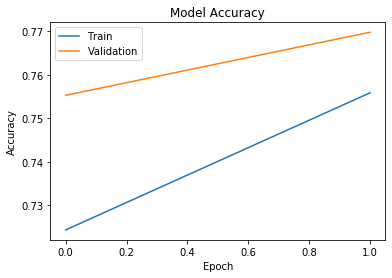

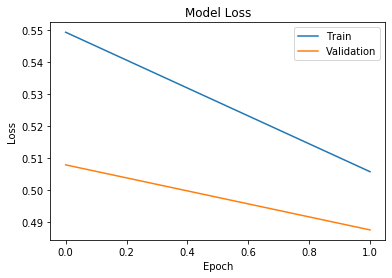

In [0]:
siamese.plot_performance_model()

In [0]:
score = siamese.model.evaluate([X_test_sentence1_seq_padded, X_test_sentence2_seq_padded],Y_test)

print("Test loss:", score[0])
print("Test Accuracy:", score[1])

35340/35340 [==============================] - 58s 2ms/step
Test loss: 0.4854567623705127
Test Accuracy: 0.7663648562979145


# Some result to compare executions

---



**Concat with diff and add**
> loss: 0.5944 - acc: 0.6969 - val_loss: 0.5663 - val_acc: 0.7166

**only concat**
> loss: 0.5948 - acc: 0.6964 - val_loss: 0.5661 - val_acc: 0.7173

**only subtract**
> loss: 0.6034 - acc: 0.6904 - val_loss: 0.5748 - val_acc: 0.7099

**concat with diff**
> loss: 0.5936 - acc: 0.6973 - val_loss: 0.5647 - val_acc: 0.7184

#### last dense activation
**case Linear**
> loss: 0.5946 - acc: 0.6967 - val_loss: 0.5684 - val_acc: 0.7148

**case relu**
> loss: 0.5668 - acc: 0.7148 - val_loss: 0.5301 - val_acc: 0.7400

**case tanh**
> loss: 0.5854 - acc: 0.7022 - val_loss: 0.5487 - val_acc: 0.7270



  ### **LSTM_unit = 128 SEQ = 64**
* Epoch 2/4
 * loss: 0.5121 - acc: 0.7465 - val_loss: 0.4925 - val_acc: 0.7602
* Epoch 3/4
 * loss: 0.4887 - acc: 0.7632 - val_loss: 0.4758 - val_acc: 0.7707
* Epoch 4/4
 * loss: 0.4724 - acc: 0.7743 - val_loss: 0.4673 - val_acc: 0.7770

### **LSTM UNIT = 128 and SEQ = 64 and DROPOUT before concat**
* Epoch 6/8
 * loss: 0.4603 - acc: 0.7813 - val_loss: 0.4637 - val_acc: 0.7798
* Epoch 7/8
 * loss: 0.4529 - acc: 0.7861 - val_loss: 0.4591 - val_acc: 0.7832
* Epoch 8/8
 * loss: 0.4448 - acc: 0.7909 - val_loss: 0.4602 - val_acc: 0.7824

# **Generating output CSV**

In [0]:
X_prod_sentence1_padded,X_prod_sentence2_padded = pre_processing.padding_sequence(X_prod,DF_COL,MAX_SEQUENCE_LENGTH)

In [0]:
result = siamese.model.predict([X_prod_sentence1_padded, X_prod_sentence2_padded])

In [0]:
class GenerateOutput():
  def generate_csv(self,result, path):
    y_classes = [np.argmax(y, axis=None, out=None) for y in result]
    indexes = [i for i in range(len(y_classes))]
    output = pd.DataFrame({'index': indexes, 'label': y_classes})
    for i,col in enumerate(DF_NEW_LABEL):
      output[DF_LABEL_COL] = output[DF_LABEL_COL].apply(lambda x: col if x == i else x)
    output.to_csv(path, index=False)

In [0]:
generator = GenerateOutput()
generator.generate_csv(result,"/content/resultat_predict.csv")

# Transfer Learning using BERT pre trained model with BI-LSTM

---



In [0]:
!pip install keras-bert

import tensorflow as tf
import keras as keras
import keras.backend as K
from keras.models import load_model

from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

import pandas as pd
import numpy as np
from tqdm import tqdm
import gc

  Created wheel for keras-bert: filename=keras_bert-0.80.0-cp36-none-any.whl size=37923 sha256=ecfc01b13f8cd6f8ad311cfae594ff9495752e90292cf92e2c4b2adeb47642dc
  Stored in directory: /root/.cache/pip/wheels/63/dc/87/3260cb91f3aa32c0f85c5375429a30c8fd988bbb48f5ee21b0
  Created wheel for keras-transformer: filename=keras_transformer-0.31.0-cp36-none-any.whl size=13385 sha256=498f1566fc1bb9b572b60c3b948587117c6d5e3d0c9e7bab236e795aa82e4d42
  Stored in directory: /root/.cache/pip/wheels/a3/c5/9a/5a5130240be614a7a6fa786765d7692ae97f82601e2161bb56
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7553 sha256=c0a91b201c19bb3ccb5a6c3d2bf0dfbaaf6c1d178c04cefe38ee76d382ec5120
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.22.0-cp36-none-any.whl size=15371 sha256=251726d2adabb1486fe8d25e72c59b55325dcc64db4736b816a9ef796c129329
  Stor

In [0]:
#CONSTANT FOR BERT

SEQ_LEN = 64
BATCH_SIZE = 128
EPOCHS = 3
LR = 1e-4

pretrained_path = '/content/datasets/kaggle-dataset/uncased_L-12_H-768_A-12/uncased_L-12_H-768_A-12'
config_path = '/content/datasets/kaggle-dataset/uncased_L-12_H-768_A-12/uncased_L-12_H-768_A-12/bert_config.json'
checkpoint_path = '/content/datasets/kaggle-dataset/uncased_L-12_H-768_A-12/uncased_L-12_H-768_A-12/bert_model.ckpt'
vocab_path = '/content/datasets/kaggle-dataset/uncased_L-12_H-768_A-12/uncased_L-12_H-768_A-12/vocab.txt'

DATA_COLUMN = 'sentence_1'
DATA_COLUMN_2 = 'sentence_2'
LABEL_COLUMN = 'label'

DF_COL =['sentence_1','sentence_2']
DF_NEW_LABEL =['neutral','entailment','contradiction']
DF_LABEL_COL = 'label'

# Class to preprocess BERT dataset

---



---



In [0]:
class BertPreProcess():
  def __init__(self):
    self.tokenizer = None

  def fit_tokenizer(self,path):
    token_dict = load_vocabulary(path)
    self.tokenizer = Tokenizer(token_dict)

  def parse_data(self,df,column1,column2):
    df[column1] = df[column1].astype(str)
    df[column2] = df[column2].astype(str)

    indices, targets = [], []
    for i in tqdm(range(len(df))):
        ids, segments = self.tokenizer.encode(first=df[column1][i],second=df[column2][i], max_len=SEQ_LEN)
        indices.append(ids)
        targets.append(df['label'][i])
    items = list(zip(indices, targets))
    indices, targets = zip(*items)
    indices = np.array(indices)

    return [indices, np.zeros_like(indices)], np.array(targets)

  def parse_prod_data(self,df,column1,column2):
    df[column1] = df[column1].astype(str)
    df[column2] = df[column2].astype(str)

    indices, targets = [], []
    for i in tqdm(range(len(df))):
        ids, segments = self.tokenizer.encode(first=df[column1][i],second=df[column2][i], max_len=SEQ_LEN)
        indices.append(ids)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

  def load_train_data_and_parse_it(self, path, column1, column2):
    df = pd.read_csv(path,delimiter="\t")
    data_x, data_y = self.parse_data(df,column1, column2)
    return data_x, data_y

  def load_prod_data_and_parse_it(self, path, column1, column2):
    df = pd.read_csv(path,delimiter="\t")
    data_x = self.parse_prod_data(df,column1, column2)
    return data_x

  def process_output_label(self,y_vector):
    dataset = pd.DataFrame({'label':y_vector})
    for label in DF_NEW_LABEL:
      dataset[label]=0
      dataset[label] = dataset[DF_LABEL_COL].apply(lambda x: 1 if x == label else 0)

    y=dataset[DF_NEW_LABEL]
    return y

In [0]:
# Tokenize encode will:
#   (1) Tokenize the sentence.
#   (2) Prepend the `[CLS]` token to the start.
#   (3) Append the `[SEP]` token to the end of the first sentence and also to the end of the second sentence
#   (4) Fuse the two sentence into one sentence
#   (5) Map tokens to their IDs.

bert_pre_processing = BertPreProcess()
bert_pre_processing.fit_tokenizer(vocab_path)
train_x, y = bert_pre_processing.load_train_data_and_parse_it('/content/datasets/kaggle-dataset/dataset_train.csv', 'sentence_1','sentence_2')
print(train_x[0][0])
y=bert_pre_processing.process_output_label(y)
print(y)

100%|██████████| 392662/392662 [02:44<00:00, 2384.48it/s]


[  101 17158  2135  6949  8301 25057  2038  2048  3937  9646  1011  4031
  1998 10505  1012   102  4031  1998 10505  2024  2054  2191  6949  8301
 25057  2147  1012   102     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
        neutral  entailment  contradiction
0             1           0              0
1             0           1              0
2             0           1              0
3             0           1              0
4             1           0              0
...         ...         ...            ...
392657        0           0              1
392658        1           0              0
392659        0           1              0
392660        1           0              0
392661        1           0              0

[392662 rows x 3 columns]


In [0]:
prod_x= bert_pre_processing.load_prod_data_and_parse_it('/content/datasets/kaggle-dataset/dataset_test_no_labels.csv', 'sentence_1','sentence_2')

100%|██████████| 19647/19647 [00:08<00:00, 2429.54it/s]


# Creating Bert Classes for the model

In [0]:
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.layers import Dense, Input
from keras.layers import Input, Bidirectional, LSTM, Dense
from keras.models import Model

class BertModel():
  def __init__(self):
    self.model = None

  def load_model(self):
    self.model = load_trained_model_from_checkpoint(
        config_path,
        checkpoint_path,
        training=True,
        trainable=True,
        seq_len=SEQ_LEN,
        )
    
  def add_bi_lstm(self):
    inputs = self.model.inputs[:2]
    dense = self.model.layers[-7].output

    model_lstm=Model(input=inputs,outputs=[dense])

    t=model_lstm.output
    x=Bidirectional(LSTM(768,return_sequences=True))(t)
    x=Bidirectional(LSTM(768,return_sequences=False))(x)

    dense=Dense(50,activation='relu')(x)
    output=Dense(3,activation='softmax',kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.2))(dense)

    self.model=Model(inputs=model_lstm.inputs,outputs=[output])

  def fit_my_model(self,x,y):
    d_steps,w_steps= calc_train_steps(
    y.shape[0],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    )
    self.model.compile(
        AdamWarmup(decay_steps=d_steps,warmup_steps=w_steps,lr=LR),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    self.model.fit(
        x,
        y,
        epochs=1,
        batch_size=BATCH_SIZE,
    )

In [0]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init_op = tf.variables_initializer(
    [v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables]
)
sess.run(init_op)

bm = BertModel()
bm.load_model()
bm.add_bi_lstm()
bm.fit_my_model(train_x,y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


Epoch 1/1


In [0]:
result = bm.model.predict(prod_x)

generator = GenerateOutput()
generator.generate_csv(result,"/content/resultat_predict_bert.csv")